## Step 1: Loading the FaceForensics Dataset and Extracting the faces from the videos 

In [ ]:
import os
import cv2
import dlib
from tqdm import tqdm
import random
import shutil
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import timm

In [1]:
print("Library Versions:")
print(f"OpenCV (cv2): {cv2.__version__}")
print(f"dlib: {dlib.__version__}")
print(f"tqdm: {tqdm.__version__}")
print(f"Pillow (PIL): {PIL.__version__}")
print(f"torch: {torch.__version__}")
print(f"torchvision: {torchvision.__version__}")
print(f"timm: {timm.__version__}")

Library Versions:


NameError: name 'cv2' is not defined

In [2]:
def extract_faces(video_path, output_dir, frame_skip=30):
    """Extract faces from a single video with 1.5x padding"""
    detector = dlib.get_frontal_face_detector()
    cap = cv2.VideoCapture(video_path)
    frame_id = 0
    saved_count = 0
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
            
        if frame_id % frame_skip == 0:
            rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            faces = detector(rgb)
            
            for i, face in enumerate(faces):
                x, y, w, h = face.left(), face.top(), face.width(), face.height()
                # Expand bounding box by 1.5x
                new_w, new_h = int(w * 1.5), int(h * 1.5)
                x = max(0, x - (new_w - w) // 2)
                y = max(0, y - (new_h - h) // 2)
                cropped = frame[y:y+new_h, x:x+new_w]
                
                if cropped.size > 0:
                    video_name = os.path.splitext(os.path.basename(video_path))[0]
                    output_path = os.path.join(output_dir, f"{video_name}_f{frame_id}_face{i}.jpg")
                    cv2.imwrite(output_path, cropped)
                    saved_count += 1
        
        frame_id += 1
    
    cap.release()
    return saved_count

def process_ff_c23(root_dir, output_root="extracted_faces"):
    """Process FaceForensics++ C23 dataset"""
    os.makedirs(output_root, exist_ok=True)
    total_files = 0
    
    # Process real videos
    real_dir = os.path.join(root_dir, "original")
    real_output = os.path.join(output_root, "real")
    os.makedirs(real_output, exist_ok=True)
    
    print("Processing real videos...")
    for video_file in tqdm(os.listdir(real_dir)):
        if video_file.endswith(".mp4"):
            video_path = os.path.join(real_dir, video_file)
            total_files += extract_faces(video_path, real_output)
    
    # Process fake videos (all manipulation methods)
    methods = ["Deepfakes", "Face2Face", "FaceShifter", "FaceSwap", "NeuralTextures"]
    
    for method in methods:
        fake_dir = os.path.join(root_dir, method)
        fake_output = os.path.join(output_root, method.lower())
        os.makedirs(fake_output, exist_ok=True)
        
        print(f"Processing {method} videos...")
        for video_file in tqdm(os.listdir(fake_dir)):
            if video_file.endswith(".mp4"):
                video_path = os.path.join(fake_dir, video_file)
                total_files += extract_faces(video_path, fake_output)
    
    print(f"\nTotal faces extracted: {total_files}")

# Run the extraction
process_ff_c23(
    root_dir="FaceForensics++_C23",  # Update with your actual path
    output_root="./extracted_faces_c23"
)

Processing real videos...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [52:29<00:00,  3.15s/it]


Processing Deepfakes videos...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [53:06<00:00,  3.19s/it]


Processing Face2Face videos...


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [1:04:30<00:00,  3.87s/it]


Processing FaceShifter videos...


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [1:02:50<00:00,  3.77s/it]


Processing FaceSwap videos...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [43:37<00:00,  2.62s/it]


Processing NeuralTextures videos...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [41:28<00:00,  2.49s/it]


Total faces extracted: 101653


## Spliting the dataset into Train , Test and Val

 ###### For simplicity, we take 7000 images from each class i.e 42000 images.
 ###### Each of these classes are split in the ratio 70:15:15 

In [1]:
def create_balanced_split(
    source_dir: str,
    target_dir: str,
    classes: list[str],
    per_class: int = 7000,
    ratios: tuple[float, float, float] = (0.7, 0.15, 0.15),
    seed: int = 42,
):
    """
    From each class folder in source_dir, sample per_class images,
    split them into train/val/test according to ratios,
    and copy into target_dir maintaining class subfolders.
    """
    assert sum(ratios) == 1.0, "ratios must sum to 1.0"
    splits = ['train', 'val', 'test']
    # compute absolute counts
    train_n = int(ratios[0] * per_class)
    val_n   = int(ratios[1] * per_class)
    test_n  = per_class - train_n - val_n

    random.seed(seed)

    # make directory tree
    for split in splits:
        for cls in classes:
            os.makedirs(os.path.join(target_dir, split, cls), exist_ok=True)

    for cls in classes:
        cls_src = os.path.join(source_dir, cls)
        all_files = [
            os.path.join(cls_src, f)
            for f in os.listdir(cls_src)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ]
        if len(all_files) < per_class:
            raise ValueError(f"Not enough images in {cls_src}: found {len(all_files)} < {per_class}")

        # sample and shuffle
        sampled = random.sample(all_files, per_class)
        random.shuffle(sampled)

        # assign
        train_files = sampled[:train_n]
        val_files   = sampled[train_n:train_n+val_n]
        test_files  = sampled[train_n+val_n:]

        # copy with progress bar
        for split_name, file_list in zip(splits, (train_files, val_files, test_files)):
            dst_folder = os.path.join(target_dir, split_name, cls)
            for src_path in tqdm(file_list, desc=f"{split_name}/{cls}", unit="img"):
                fname = os.path.basename(src_path)
                dst_path = os.path.join(dst_folder, fname)
                shutil.copy2(src_path, dst_path)

if __name__ == "__main__":
    SOURCE_DIR = "extracted_faces_c23"    # your original 7-class folder
    TARGET_DIR = "new_split_dataset" # where the new train/val/test will go
    CLASSES    = [
        "deepfakes", "face2face", "faceshifter",
        "faceswap", "neuraltextures", "real"
    ]
    create_balanced_split(
        source_dir=SOURCE_DIR,
        target_dir=TARGET_DIR,
        classes=CLASSES,
        per_class=7000,
        ratios=(0.7, 0.15, 0.15),
        seed=1234
    )
    print("New split created at", TARGET_DIR)

test/real: 100%|█████████████████████████████████████████████████████████████████| 1050/1050 [00:05<00:00, 202.12img/s]

New split created at new_split_dataset


In [4]:
def count_images_in_split(split_dir):
    """
    Counts images in each class folder under the given split (train/val/test).
    """
    total = 0
    print(f"\n📁 Counting in: {split_dir}")
    
    for class_name in os.listdir(split_dir):
        class_dir = os.path.join(split_dir, class_name)
        if not os.path.isdir(class_dir):
            continue
        
        count = sum(
            1 for fname in os.listdir(class_dir)
            if fname.lower().endswith(('.jpg', '.jpeg', '.png'))
        )
        total += count
        print(f"  - {class_name:<15}: {count} images")
    
    print(f"✅ Total in {os.path.basename(split_dir)}: {total} images")
    return total

# === Main Count ===
base_dir = "new_split_dataset"
grand_total = 0

for split in ['train', 'val', 'test']:
    split_path = os.path.join(base_dir, split)
    grand_total += count_images_in_split(split_path)

print(f"\n🧮 Grand Total across all splits: {grand_total} images")


📁 Counting in: new_split_dataset\train
  - deepfakes      : 4900 images
  - face2face      : 4900 images
  - faceshifter    : 4900 images
  - faceswap       : 4900 images
  - neuraltextures : 4900 images
  - real           : 4900 images
✅ Total in train: 29400 images

📁 Counting in: new_split_dataset\val
  - deepfakes      : 1050 images
  - face2face      : 1050 images
  - faceshifter    : 1050 images
  - faceswap       : 1050 images
  - neuraltextures : 1050 images
  - real           : 1050 images
✅ Total in val: 6300 images

📁 Counting in: new_split_dataset\test
  - deepfakes      : 1050 images
  - face2face      : 1050 images
  - faceshifter    : 1050 images
  - faceswap       : 1050 images
  - neuraltextures : 1050 images
  - real           : 1050 images
✅ Total in test: 6300 images

🧮 Grand Total across all splits: 42000 images


## Data leveling with lazy loading

In [3]:
# path to the train folder
base_dir = "new_split_dataset/train"

# transformation code 
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Main loop of image loading
images = []
labels = []

for class_name in sorted(os.listdir(base_dir)):
    class_path = os.path.join(base_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    label = 1 if class_name.lower() == "real" else 0
    print(f"📁 Processing: {class_name} (label={label})")

    for fname in os.listdir(class_path):
        if fname.lower().endswith((".jpg", ".jpeg", ".png")):
            img_path = os.path.join(class_path, fname)
            try:
                img = Image.open(img_path).convert("RGB")
                img_tensor = transform(img)
                images.append(img_tensor)
                labels.append(label)
            except Exception as e:
                print(f"[WARNING] Skipped {img_path}: {e}")

# --- Stack into tensors ---
image_tensor = torch.stack(images)
label_tensor = torch.tensor(labels, dtype=torch.long)

print(f"\n✅ Loaded {len(image_tensor)} images")

# --- Creating Dataloader (single worker to avoid pickling) ---
from torch.utils.data import TensorDataset
dataset = TensorDataset(image_tensor, label_tensor)
loader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=0)

# --- Previewing  a few batches of tensors ---
for i, (x, y) in enumerate(loader):
    print(f"Batch {i+1}: {x.shape}, Labels: {y[:5]}")
    if i == 2:
        break

📁 Processing: deepfakes (label=0)
📁 Processing: face2face (label=0)
📁 Processing: faceshifter (label=0)
📁 Processing: faceswap (label=0)
📁 Processing: neuraltextures (label=0)
📁 Processing: real (label=1)

✅ Loaded 29400 images
Batch 1: torch.Size([8, 3, 256, 256]), Labels: tensor([1, 1, 0, 0, 0])
Batch 2: torch.Size([8, 3, 256, 256]), Labels: tensor([0, 0, 0, 0, 0])
Batch 3: torch.Size([8, 3, 256, 256]), Labels: tensor([0, 1, 0, 1, 0])


In [4]:
train_image_tensor = image_tensor
train_label_tensor = label_tensor

In [5]:
print(train_image_tensor.shape)   
print(train_label_tensor.shape)

torch.Size([29400, 3, 256, 256])
torch.Size([29400])


In [14]:
# setting the test dataset folder path
base_dir = "new_split_dataset/test"

# Code for transformation
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Loop for loading images 
images = []
labels = []

for class_name in sorted(os.listdir(base_dir)):
    class_path = os.path.join(base_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    label = 1 if class_name.lower() == "real" else 0
    print(f"📁 Processing: {class_name} (label={label})")

    for fname in os.listdir(class_path):
        if fname.lower().endswith((".jpg", ".jpeg", ".png")):
            img_path = os.path.join(class_path, fname)
            try:
                img = Image.open(img_path).convert("RGB")
                img_tensor = transform(img)
                images.append(img_tensor)
                labels.append(label)
            except Exception as e:
                print(f"[WARNING] Skipped {img_path}: {e}")

# --- Stack into tensors ---
image_tensor = torch.stack(images)
label_tensor = torch.tensor(labels, dtype=torch.long)

print(f"\n✅ Loaded {len(image_tensor)} images")

# --- Create DataLoader (single worker to avoid pickling) ---
from torch.utils.data import TensorDataset
dataset = TensorDataset(image_tensor, label_tensor)
loader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=0)

# --- Preview a few batches ---
for i, (x, y) in enumerate(loader):
    print(f"Batch {i+1}: {x.shape}, Labels: {y[:5]}")
    if i == 2:
        break

📁 Processing: deepfakes (label=0)
📁 Processing: face2face (label=0)
📁 Processing: faceshifter (label=0)
📁 Processing: faceswap (label=0)
📁 Processing: neuraltextures (label=0)
📁 Processing: real (label=1)

✅ Loaded 6300 images
Batch 1: torch.Size([8, 3, 256, 256]), Labels: tensor([0, 0, 0, 1, 0])
Batch 2: torch.Size([8, 3, 256, 256]), Labels: tensor([0, 1, 1, 1, 0])
Batch 3: torch.Size([8, 3, 256, 256]), Labels: tensor([0, 0, 0, 1, 0])


In [15]:
test_image_tensor = image_tensor
test_label_tensor = label_tensor

In [16]:
print(test_image_tensor.shape)   
print(test_label_tensor.shape)

torch.Size([6300, 3, 256, 256])
torch.Size([6300])


In [21]:
# --- Set root path ---
base_dir = "new_split_dataset/val"

# --- Transform ---
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# --- Image loading loop ---
images = []
labels = []

for class_name in sorted(os.listdir(base_dir)):
    class_path = os.path.join(base_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    label = 1 if class_name.lower() == "real" else 0
    print(f"📁 Processing: {class_name} (label={label})")

    for fname in os.listdir(class_path):
        if fname.lower().endswith((".jpg", ".jpeg", ".png")):
            img_path = os.path.join(class_path, fname)
            try:
                img = Image.open(img_path).convert("RGB")
                img_tensor = transform(img)
                images.append(img_tensor)
                labels.append(label)
            except Exception as e:
                print(f"[WARNING] Skipped {img_path}: {e}")

# --- Stack into tensors ---
image_tensor = torch.stack(images)
label_tensor = torch.tensor(labels, dtype=torch.long)

print(f"\n✅ Loaded {len(image_tensor)} images")

# --- Create DataLoader (single worker to avoid pickling) ---
from torch.utils.data import TensorDataset
dataset = TensorDataset(image_tensor, label_tensor)
loader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=0)

# --- Preview a few batches ---
for i, (x, y) in enumerate(loader):
    print(f"Batch {i+1}: {x.shape}, Labels: {y[:5]}")
    if i == 2:
        break

📁 Processing: deepfakes (label=0)
📁 Processing: face2face (label=0)
📁 Processing: faceshifter (label=0)
📁 Processing: faceswap (label=0)
📁 Processing: neuraltextures (label=0)
📁 Processing: real (label=1)

✅ Loaded 6300 images
Batch 1: torch.Size([8, 3, 256, 256]), Labels: tensor([1, 0, 0, 0, 1])
Batch 2: torch.Size([8, 3, 256, 256]), Labels: tensor([0, 0, 0, 0, 0])
Batch 3: torch.Size([8, 3, 256, 256]), Labels: tensor([0, 0, 0, 0, 0])


In [22]:
val_image_tensor = image_tensor
val_label_tensor = label_tensor

In [23]:
print(val_image_tensor.shape)   
print(val_label_tensor.shape)

torch.Size([6300, 3, 256, 256])
torch.Size([6300])


In [24]:
train_dataset = TensorDataset(train_image_tensor, train_label_tensor)
val_dataset = TensorDataset(val_image_tensor, val_label_tensor)
test_dataset = TensorDataset(test_image_tensor, test_label_tensor)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

## Model Setup (Xception + Loss + Optimizer)

In [25]:
# checking the availability of Cuda GPU else we will switch to CPU 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# loading the xception model 
model = timm.create_model('xception', pretrained=True, num_classes=1)
model = model.to(device)

# Creating the loss function and optimizer here we have used the Adam optimizer 
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

## Training and Validation Loop

In [26]:
# training loops for 10 epochs

num_epochs = 10
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(num_epochs):
    print(f"\n[Epoch {epoch+1}/{num_epochs}]")

    # training loop 
    model.train()
    total_loss, correct, total = 0, 0, 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device).float()

        out = model(x).squeeze()
        loss = criterion(out, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = (torch.sigmoid(out) > 0.5).float()
        correct += (preds == y).sum().item()
        total += y.size(0)

    train_loss = total_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")

    # validation loop on our val dataset 
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device).float()

            out = model(x).squeeze()
            loss = criterion(out, y)

            total_loss += loss.item()
            preds = (torch.sigmoid(out) > 0.5).float()
            correct += (preds == y).sum().item()
            total += y.size(0)

    val_loss = total_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")


[Epoch 1/10]
Train Loss: 0.2663 | Train Acc: 0.8897
Val Loss: 0.1591 | Val Acc: 0.9352

[Epoch 2/10]
Train Loss: 0.1363 | Train Acc: 0.9474
Val Loss: 0.1480 | Val Acc: 0.9441

[Epoch 3/10]
Train Loss: 0.0901 | Train Acc: 0.9664
Val Loss: 0.1625 | Val Acc: 0.9383

[Epoch 4/10]
Train Loss: 0.0624 | Train Acc: 0.9772
Val Loss: 0.1563 | Val Acc: 0.9486

[Epoch 5/10]
Train Loss: 0.0503 | Train Acc: 0.9818
Val Loss: 0.1607 | Val Acc: 0.9440

[Epoch 6/10]
Train Loss: 0.0420 | Train Acc: 0.9847
Val Loss: 0.1402 | Val Acc: 0.9548

[Epoch 7/10]
Train Loss: 0.0378 | Train Acc: 0.9864
Val Loss: 0.1422 | Val Acc: 0.9583

[Epoch 8/10]
Train Loss: 0.0328 | Train Acc: 0.9880
Val Loss: 0.1702 | Val Acc: 0.9525

[Epoch 9/10]
Train Loss: 0.0308 | Train Acc: 0.9897
Val Loss: 0.1317 | Val Acc: 0.9532

[Epoch 10/10]
Train Loss: 0.0264 | Train Acc: 0.9907
Val Loss: 0.1398 | Val Acc: 0.9532


## Saving Model and displaying the Classification Report and Confusion Matrix 

In [27]:
torch.save(model.state_dict(), "xception_faceforensics_final.pt")
print("✅ Model saved!")

✅ Model saved!


In [28]:
# from the saved training logs file, we ge the losses and accruacy values for both training and validation
with open("training_logs.pkl", "wb") as f:
    pickle.dump({
        "train_losses": train_losses,
        "train_accs": train_accs,
        "val_losses": val_losses,
        "val_accs": val_accs,
    }, f)

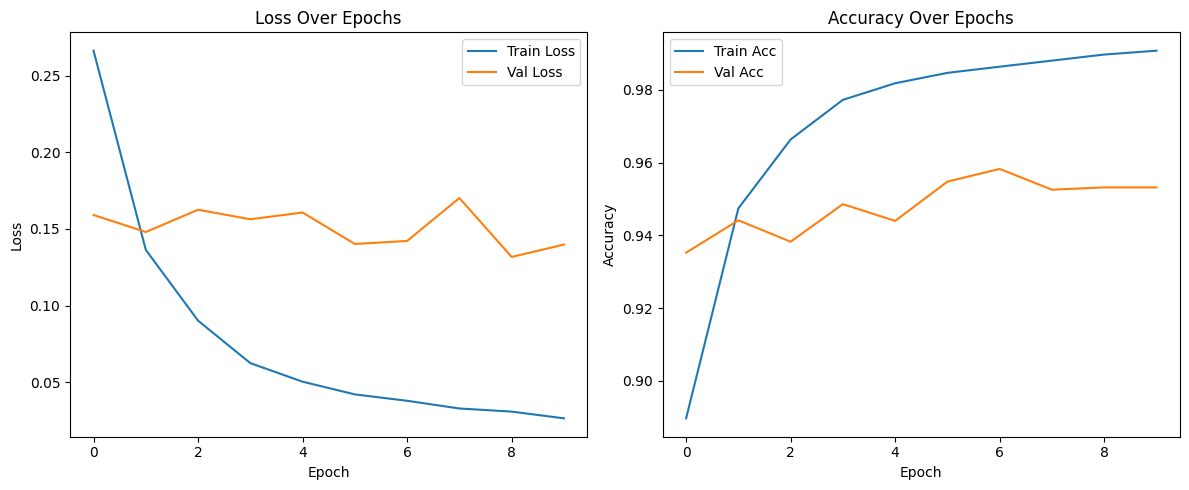

In [29]:
# plot of the accuracy loss curves for both Training and validation dataset using the matplotlib

import matplotlib.pyplot as plt

def plot_curves(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.title("Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label="Train Acc")
    plt.plot(val_accs, label="Val Acc")
    plt.title("Accuracy Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_curves(train_losses, val_losses, train_accs, val_accs)

# Evaluation of the model on the Test Dataset 

In [30]:
# evaluation function 
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device).float()
            out = model(x).squeeze()
            preds = (torch.sigmoid(out) > 0.5).float()
            correct += (preds == y).sum().item()
            total += y.size(0)
    print(f"🎯 Final Test Accuracy: {correct / total:.4f}")

evaluate(model, test_loader)

🎯 Final Test Accuracy: 0.9541


### Classification Report 

In [31]:

from sklearn.metrics import classification_report

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device).float()
        out = model(x).squeeze()
        preds = (torch.sigmoid(out) > 0.5).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=["Fake", "Real"]))

              precision    recall  f1-score   support

        Fake       0.96      0.99      0.97      5250
        Real       0.92      0.79      0.85      1050

    accuracy                           0.95      6300
   macro avg       0.94      0.89      0.91      6300
weighted avg       0.95      0.95      0.95      6300



## Confusion matrix

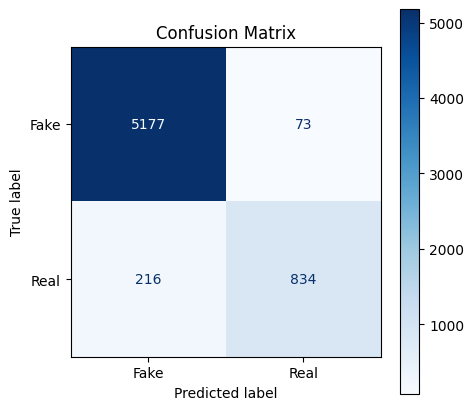

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device).float()
        outputs = model(x).squeeze()
        preds = (torch.sigmoid(outputs) > 0.5).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title("Confusion Matrix")
plt.show()

## Testing the model with 10 random videos 

In [58]:
import os
import cv2
import torch
import timm
import random
import dlib
import numpy as np
from PIL import Image
from tqdm import tqdm
from torchvision import transforms

# --- Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Model Loading ---
model = timm.create_model("legacy_xception", pretrained=False, num_classes=1)
model.load_state_dict(torch.load("xception_faceforensics_final.pt", map_location=device))
model.to(device)
model.eval()

# --- Transform (same as training) ---
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# --- Dlib Face Detector ---
face_detector = dlib.get_frontal_face_detector()

# --- Face-based Predict Frame Function ---
def predict_frame_with_face(frame):
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    faces = face_detector(rgb)

    for face in faces:
        x, y, w, h = face.left(), face.top(), face.width(), face.height()
        new_w, new_h = int(w * 1.5), int(h * 1.5)
        x = max(0, x - (new_w - w) // 2)
        y = max(0, y - (new_h - h) // 2)
        cropped = frame[y:y+new_h, x:x+new_w]

        if cropped.size == 0:
            continue

        img = Image.fromarray(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB)).convert("RGB")
        img_tensor = transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(img_tensor).squeeze()
            prob = torch.sigmoid(output).item()
            pred_class = 1 if prob > 0.5 else 0
            label = "Real" if pred_class == 1 else "Fake"
        return label, prob, pred_class

    # If no face is detected
    return "NoFace", 0.0, -1

# here is the file_path of the directory, you can change this file path as per your needs to check different classes
video_dir = "R:/Deepfake/FaceForensics++_C23/original" 
video_files = [f for f in os.listdir(video_dir) if f.endswith(".mp4")]
selected_videos = random.sample(video_files, min(10, len(video_files)))

# loop for processing 10 videos 
for idx, video_file in enumerate(selected_videos, start=1):
    video_path = os.path.join(video_dir, video_file)
    cap = cv2.VideoCapture(video_path)

    print(f"\n🎬 [{idx}/10] Processing: {video_file}")

    frame_count = 0
    real_count, fake_count, skipped = 0, 0, 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % 30 == 0: 
            label, prob, pred_class = predict_frame_with_face(frame)

            if pred_class == -1:
                skipped += 1
            elif pred_class == 1:
                real_count += 1
            else:
                fake_count += 1

        frame_count += 1

    cap.release()

    # final summary results based on the total frames counted as fake and real 
    total = real_count + fake_count
    real_pct = (real_count / total) * 100 if total else 0
    fake_pct = (fake_count / total) * 100 if total else 0
    verdict = "Real" if real_count > fake_count else "Fake"

    print(f"🧮 Real: {real_count} ({real_pct:.2f}%) | Fake: {fake_count} ({fake_pct:.2f}%) | Skipped (no face): {skipped}")
    print(f"✅ Final Verdict: {verdict}")

cv2.destroyAllWindows()


🎬 [1/10] Processing: 733.mp4
🧮 Real: 18 (100.00%) | Fake: 0 (0.00%) | Skipped (no face): 0
✅ Final Verdict: Real

🎬 [2/10] Processing: 539.mp4
🧮 Real: 10 (90.91%) | Fake: 1 (9.09%) | Skipped (no face): 0
✅ Final Verdict: Real

🎬 [3/10] Processing: 193.mp4
🧮 Real: 13 (100.00%) | Fake: 0 (0.00%) | Skipped (no face): 0
✅ Final Verdict: Real

🎬 [4/10] Processing: 223.mp4
🧮 Real: 12 (100.00%) | Fake: 0 (0.00%) | Skipped (no face): 0
✅ Final Verdict: Real

🎬 [5/10] Processing: 370.mp4
🧮 Real: 13 (92.86%) | Fake: 1 (7.14%) | Skipped (no face): 0
✅ Final Verdict: Real

🎬 [6/10] Processing: 108.mp4
🧮 Real: 10 (100.00%) | Fake: 0 (0.00%) | Skipped (no face): 0
✅ Final Verdict: Real

🎬 [7/10] Processing: 583.mp4
🧮 Real: 16 (100.00%) | Fake: 0 (0.00%) | Skipped (no face): 0
✅ Final Verdict: Real

🎬 [8/10] Processing: 736.mp4
🧮 Real: 11 (78.57%) | Fake: 3 (21.43%) | Skipped (no face): 0
✅ Final Verdict: Real

🎬 [9/10] Processing: 131.mp4
🧮 Real: 8 (72.73%) | Fake: 3 (27.27%) | Skipped (no face): 0